# Github repository

https://github.com/noong99/stats507-coursework/tree/main/Project

## Dataset
Datasets: finance-financialmodelingprep-stock-news-sentiments-rss-feed  
https://huggingface.co/datasets/NickyNicky/finance-financialmodelingprep-stock-news-sentiments-rss-feed

## Hugging Face Model

https://huggingface.co/ProsusAI/finbert

------

For using dataset and models provided by HuggingFace, install below packages first.

In [5]:
# !pip install transformers
# !pip install datasets

In [6]:
import pandas as pd
import scipy
import seaborn as sns
import matplotlib.pyplot as plt

from datasets import load_dataset

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
import torch
import torch.nn.functional as F
import  numpy as np
# from pytorch_pretrained_bert import BertTokenizr
# from bertModel import BertClassification
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, AdamW

### Download dataset from Huggingface Website


In [7]:
# Use dataset
df_original = pd.read_parquet("hf://datasets/NickyNicky/finance-financialmodelingprep-stock-news-sentiments-rss-feed/data/train-00000-of-00001-ccd537eba2831636.parquet")
df_original.head()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


,symbol,publishedDate,title,image,site,text,url,sentiment,sentimentScore
0,HE,2023-10-04T21:54:28.000Z,"HE REMINDER: Kessler Topaz Meltzer & Check, LL...",/next-assets/images/schema-image-default.png,benzinga,"RADNOR, Pa., Oct. 04, 2023 (GLOBE NEWSWIRE) --...",https://www.benzinga.com/pressreleases/23/10/g...,Negative,-0.6417
1,CRS,2023-10-04T21:40:00.000Z,Carpenter Technology Announces Conference Call...,https://ml.globenewswire.com/Resource/Download...,globenewswire,"PHILADELPHIA, Oct. 04, 2023 (GLOBE NEWSWIRE) -...",https://www.globenewswire.com/news-release/202...,Positive,0.4767
2,BB,2023-10-04T21:34:09.000Z,What's Going On With BlackBerry Stock After Ho...,https://cdn.benzinga.com/files/images/story/20...,benzinga,BlackBerry Ltd (NYSE: BB) shares are trading h...,https://www.benzinga.com/news/23/10/35098537/w...,Positive,0.9895
3,TECK,2023-10-04T21:17:00.000Z,Teck to Release Third Quarter 2023 Results on ...,https://ml.globenewswire.com/Resource/Download...,globenewswire,"VANCOUVER, British Columbia, Oct. 04, 2023 (GL...",https://www.globenewswire.com/news-release/202...,Positive,0.8300
4,AGF,2023-10-04T21:13:38.000Z,AGF Reports September 2023 Assets Under Manage...,/next-assets/images/schema-image-default.png,benzinga,"TORONTO, Oct. 04, 2023 (GLOBE NEWSWIRE) -- AGF...",https://www.benzinga.com/pressreleases/23/10/g...,Positive,0.9768


# 1. Data Processing

### 1-1. Data Visualization - EDA Analysis

In [8]:
df_original.dtypes

,0
symbol,object
publishedDate,object
title,object
image,object
site,object
text,object
url,object
sentiment,object
sentimentScore,float64


In [9]:
df_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142000 entries, 0 to 141999
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   symbol          142000 non-null  object 
 1   publishedDate   142000 non-null  object 
 2   title           142000 non-null  object 
 3   image           142000 non-null  object 
 4   site            142000 non-null  object 
 5   text            142000 non-null  object 
 6   url             142000 non-null  object 
 7   sentiment       142000 non-null  object 
 8   sentimentScore  140336 non-null  float64
dtypes: float64(1), object(8)
memory usage: 9.8+ MB


In [10]:
print("Data shape: {} \n".format(df_original.shape))
print("Sentiment Distribution : \n{}".format(df_original.sentiment.value_counts()))

Data shape: (142000, 9) 

Sentiment Distribution : 
sentiment
Positive    125630
Negative     14521
Neutral       1849
Name: count, dtype: int64


Text(0, 0.5, 'Number of News')

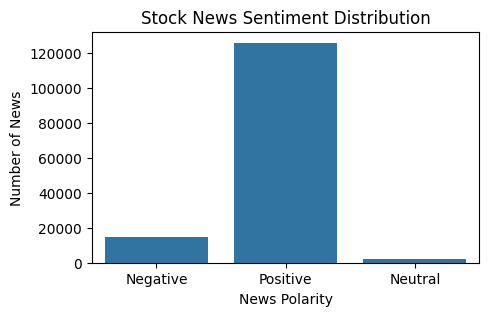

In [11]:
# Plot to visualize the difference in sentiments
plt.figure(figsize = (5,3))
sns.countplot(x = 'sentiment', data = df_original)
plt.title('Stock News Sentiment Distribution')
plt.xlabel('News Polarity')
plt.ylabel('Number of News')

### 1-2. Data Preprocessing

From here, we will perform data preprocessing and assign this DataFrame to df

In [12]:
# Dataframe after data preprocessing
df = df_original.copy()

In [13]:
# Change the data type of 'publishedDate' column into datetime and also make the format uniform(yyyy-mm-dd)
# In the later data preprocessing step, this publishedDate will be removed, but for better readability, we will first convert its format
df['publishedDate'] = pd.to_datetime(df['publishedDate']).dt.strftime('%Y-%m-%d')

In [14]:
# Create a new column in which title and text are combined into one column
df['Title_Text'] = df['title'] + df['text']
df.head()

,symbol,publishedDate,title,image,site,text,url,sentiment,sentimentScore,Title_Text
0,HE,2023-10-04,"HE REMINDER: Kessler Topaz Meltzer & Check, LL...",/next-assets/images/schema-image-default.png,benzinga,"RADNOR, Pa., Oct. 04, 2023 (GLOBE NEWSWIRE) --...",https://www.benzinga.com/pressreleases/23/10/g...,Negative,-0.6417,"HE REMINDER: Kessler Topaz Meltzer & Check, LL..."
1,CRS,2023-10-04,Carpenter Technology Announces Conference Call...,https://ml.globenewswire.com/Resource/Download...,globenewswire,"PHILADELPHIA, Oct. 04, 2023 (GLOBE NEWSWIRE) -...",https://www.globenewswire.com/news-release/202...,Positive,0.4767,Carpenter Technology Announces Conference Call...
2,BB,2023-10-04,What's Going On With BlackBerry Stock After Ho...,https://cdn.benzinga.com/files/images/story/20...,benzinga,BlackBerry Ltd (NYSE: BB) shares are trading h...,https://www.benzinga.com/news/23/10/35098537/w...,Positive,0.9895,What's Going On With BlackBerry Stock After Ho...
3,TECK,2023-10-04,Teck to Release Third Quarter 2023 Results on ...,https://ml.globenewswire.com/Resource/Download...,globenewswire,"VANCOUVER, British Columbia, Oct. 04, 2023 (GL...",https://www.globenewswire.com/news-release/202...,Positive,0.8300,Teck to Release Third Quarter 2023 Results on ...
4,AGF,2023-10-04,AGF Reports September 2023 Assets Under Manage...,/next-assets/images/schema-image-default.png,benzinga,"TORONTO, Oct. 04, 2023 (GLOBE NEWSWIRE) -- AGF...",https://www.benzinga.com/pressreleases/23/10/g...,Positive,0.9768,AGF Reports September 2023 Assets Under Manage...


In [15]:
# Remove columns that are not needed for prediction
df = df.drop(columns = ['symbol', 'publishedDate', 'title', 'image', 'site', 'text', 'url'])

In [16]:
# Check null values in sentimentScore
print("The number of rows where sentimentScore is null:", len(df[df['sentimentScore'].isnull()]))
print("The number of rows where sentimentScore is null and sentiment is Neutral:",len(df[(df['sentimentScore'].isnull() & df['sentiment'] == 'Neutral')]))

print("\nData rows where sentimentScore is null")
df[df['sentimentScore'].isnull()]

The number of rows where sentimentScore is null: 1664
The number of rows where sentimentScore is null and sentiment is Neutral: 0

Data rows where sentimentScore is null


,sentiment,sentimentScore,Title_Text
139928,Positive,NaN,Bed Bath & Beyond Falls as Cohen Files to Sell...
139933,Positive,NaN,bluebird bio's Zynteglo Gets FDA Approval - Li...
139934,Negative,NaN,Wolfspeed Shares Rise High After Q4 Results To...
139939,Positive,NaN,Wabash National Corporation Announces Quarterl...
139940,Positive,NaN,Emclaire Financial Corp Announces Quarterly Di...
...,...,...,...
141995,Positive,NaN,aTyr Pharma Announces Inducement Grants Under ...
141996,Positive,NaN,LMP Automotive Holdings Announces Voluntary NA...
141997,Positive,NaN,Covenant Logistics Group Announces Filing of U...
141998,Positive,NaN,Grindrod Shipping Holdings Ltd. Announces Date...


We can infer the sentiment even without the sentimentScore, so the absence of sentimentScore values is not a critical issue.  
If the sentiment were Neutral, we could replace the sentimentScore with 0, but there are no Neutral cases.  
For Positive and Negative sentiments, we could use the mean value to replace the nulls, but to ensure more accurate fitting, remove the rows with null sentimentScore values instead of replacing them.
However, since there are sufficient data, we will remove the 1,664 rows where sentimentScore is null.

In [17]:
# Remove null values in sentimentScore
df = df.dropna(subset = ['sentimentScore'])

In [18]:
# Performing random sampling as the dataset is too large
df_sampled = df.sample(n=4000, random_state=129)

# Check the size of the sampled data
print(df_sampled.shape)

(4000, 3)


In [19]:
# Convert Dataframe to text data
news_data = df_sampled.to_csv('news_data_sampled.csv', index = False, encoding = 'utf-8')

Additionally, if you want to use the newly created data for modeling by modifying the original dataset, you can dodwnload the `news_data.csv` file and run the code below

In [20]:
file_path = 'news_data_sampled.csv'
df = pd.read_csv(file_path)

In [21]:
# Encode the sentiment column
# 0: Negative, 1: Neutral, 2: Positive
le = LabelEncoder()
df['sentiment'] = le.fit_transform(df['sentiment'])
df['sentiment'].value_counts() #sentiment is means label

,count
sentiment,
2,3567
0,382
1,51


As we can see the class imbalance here, we can try stratify option when splitting the data below.  
Furthermore, we will try 1. Oversampling(SMOTE), 2. Class Weight to resolve this class imbalance problem.

## 2. FinBERT Model

### 2-1. Data Preparation with FinBERT Model

Let's split the data into train, test and validation.  
Use the train data to train the model, the validation data to check the performance of the model, and the test data to check how the model performs on new data.

In [22]:
# Set Title_Text as texts, sentiment as labels
texts = df['Title_Text'].values
labels = df['sentiment'].values
scores = df['sentimentScore'].values

# Split the data into train, validation, test set
# Set train:valid:test = 6:2:2 and apply stratify
xtrain, xtemp, ytrain, ytemp, scores_train, scores_temp= train_test_split(texts, labels, scores, test_size = 0.4, random_state = 129, stratify = labels)
xtest, xvalid, ytest, yvalid, scores_valid, scores_test= train_test_split(xtemp, ytemp, scores_temp, test_size=0.5, random_state = 129, stratify = ytemp)

# Check how many data in one each dataset
print(f"Train size: {len(xtrain)}")
print(f"Validation size: {len(xvalid)}")
print(f"Train size: {len(xtest)}")

Train size: 2400
Validation size: 800
Train size: 800


### 2-2. Tokenization

Download the Pre-trained Model and Tokenizer from Huggingface Website

In [23]:
tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")

tokenizer_config.json:   0%|          | 0.00/252 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/758 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [24]:
def tokenize_function(x):
    return tokenizer(list(x), padding="max_length", truncation=True, max_length=128, return_tensors="pt")

train_encodings = tokenize_function(xtrain)
val_encodings = tokenize_function(xvalid)
test_encodings = tokenize_function(xtest)

### 2-3. Define PyTorch Dataset

In [25]:
# Define Pytorch Dataset
class FinDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
        self.scores = scores

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        item["scores"] = torch.tensor(self.scores[idx], dtype = torch.float)
        return item

Oversampling: Apply SMOTE to resolve the imbalance problem

In [26]:
# Apply SMOTE
smote = SMOTE(random_state=129)
train_features = train_encodings['input_ids'].numpy()
ytrain_resampled, y_resampled = smote.fit_resample(train_features, ytrain)

# Expand Attention mask and Token Type IDs
attention_mask_resampled = np.tile(
    train_encodings["attention_mask"].numpy(),
    (len(ytrain_resampled) // len(train_encodings["attention_mask"]) + 1, 1)
)[:len(ytrain_resampled)]

token_type_ids_resampled = np.tile(
    train_encodings["token_type_ids"].numpy(),
    (len(ytrain_resampled) // len(train_encodings["token_type_ids"]) + 1, 1))[:len(ytrain_resampled)]


In [27]:
# Adjust data size
num_samples = 4000  # Original data size

train_encodings_resampled = {
    "input_ids": torch.tensor(ytrain_resampled[:num_samples]),
    "attention_mask": torch.tensor(attention_mask_resampled[:num_samples]),
    "token_type_ids": torch.tensor(token_type_ids_resampled[:num_samples]),
}

y_resampled = y_resampled[:num_samples]

train_dataset = FinDataset(train_encodings_resampled, y_resampled)
val_dataset = FinDataset(val_encodings, yvalid)
test_dataset = FinDataset(test_encodings, ytest)

In [28]:
# Check these shapes are same or not
print(f"Input IDs shape: {train_encodings_resampled['input_ids'].shape}")
print(f"Attention Mask shape: {train_encodings_resampled['attention_mask'].shape}")
print(f"Token Type IDs shape: {train_encodings_resampled['token_type_ids'].shape}")
print(f"Labels shape: {len(y_resampled)}")
print(f"Train Dataset size: {len(train_dataset)}")


Input IDs shape: torch.Size([4000, 128])
Attention Mask shape: torch.Size([4000, 128])
Token Type IDs shape: torch.Size([4000, 128])
Labels shape: 4000
Train Dataset size: 4000


In [29]:
# Compute class weight
class_weights = compute_class_weight('balanced', classes=np.unique(y_resampled), y=y_resampled)
class_weights = torch.tensor(class_weights, dtype=torch.float)

### 2-4. Define model - Training Arguments

Instead of simple classification based solely on `sentiment`, incorporate `sentimentScore` to improve accuracy

In [30]:
# Define custom loss function
def compute_loss(outputs, labels, scores):
    loss_func = torch.nn.CrossEntropyLoss(weight=class_weights)
    weighted_loss = loss_func(outputs.logits, labels)
    # apply weight using 'sentimentScore'
    adjusted_loss = (scores * weighted_loss).mean()
    return adjusted_loss

In [31]:
# Load FinBERT pre-trained model
model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert", num_labels = 3)

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

In [32]:
# Set the training Arguments
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    save_total_limit=2
)

In [33]:
# Define evaluation metrics function
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    acc = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average="weighted")
    return {"accuracy": acc, "f1": f1}

In [34]:
# Define Trainer
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels")
        scores = inputs.pop("scores")  # sentimentScore
        outputs = model(**inputs)
        loss = compute_loss(outputs, labels, scores)  # Custom loss function
        return (loss, outputs) if return_outputs else loss

trainer = Trainer(
    model = model,
    args = training_args,
    train_dataset = train_dataset,
    eval_dataset = val_dataset,
    compute_metrics=compute_metrics
)

### 2-5. Model train and evaluation

Fine-tuned on the data and evaluate on testing set

In [35]:
# Training model
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.278200,0.462300,0.892500,0.841803
2,0.227800,0.491290,0.898750,0.864360
3,0.129000,0.584622,0.883750,0.866753


TrainOutput(global_step=3000, training_loss=0.22261749776204426, metrics={'train_runtime': 13829.5778, 'train_samples_per_second': 0.868, 'train_steps_per_second': 0.217, 'total_flos': 789340253184000.0, 'train_loss': 0.22261749776204426, 'epoch': 3.0})

In [36]:
# Save a model
trainer.save_model("./save_model")

In [45]:
tokenizer.save_pretrained("./save_model")

('./save_model/tokenizer_config.json',
 './save_model/special_tokens_map.json',
 './save_model/vocab.txt',
 './save_model/added_tokens.json',
 './save_model/tokenizer.json')

Define loss function applying Class Weights to resolve the imbalance problem

In [38]:
# Model Evaluation
val_results = trainer.evaluate(eval_dataset = val_dataset)
print("Validation Results: ", val_results)

Validation Results:  {'eval_loss': 0.4912899136543274, 'eval_accuracy': 0.89875, 'eval_f1': 0.8643601328903654, 'eval_runtime': 246.5963, 'eval_samples_per_second': 3.244, 'eval_steps_per_second': 0.811, 'epoch': 3.0}


In [39]:
test_predictions = trainer.predict(test_dataset)
ytest_pred = np.argmax(test_predictions.predictions, axis = 1)
print(classification_report(ytest, ytest_pred, target_names = ["Negative", "Neutral", "Positive"]))

              precision    recall  f1-score   support

    Negative       0.70      0.18      0.29        77
     Neutral       0.80      0.40      0.53        10
    Positive       0.91      0.99      0.95       713

    accuracy                           0.91       800
   macro avg       0.80      0.53      0.59       800
weighted avg       0.89      0.91      0.88       800



### 2.6 Using Model and predict

In [48]:
# Load a saved model
model_fin = AutoModelForSequenceClassification.from_pretrained("./save_model")
model.eval() # Evaluation mode

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [51]:
# Load the tokenizer
tokenizer_fin = AutoTokenizer.from_pretrained("./save_model")

Define a function that returns sentiment analysis result of specified input

In [55]:
# Class-Label mapping
class_labels = {0: "negative", 1: "neutral", 2: "positive"}

In [56]:
def predict_sentiment(sentence, model, tokenizer):
    # Input Preprocessing
    encoded = tokenizer(sentence, padding='max_length', truncation=True, max_length=128, return_tensors='pt')
    input_ids = encoded['input_ids']
    attention_mask = encoded['attention_mask']

    # Prediction
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        probabilities = torch.softmax(logits, dim=1)
        predicted_class = torch.argmax(probabilities, dim=1).item()

    predicted_label = class_labels[predicted_class]
    return predicted_label, probabilities

In [59]:
# Input data for prediction
sentence = "Goldman Sachs analysts say there's still potential for more stock gains" # Put sentence here

# Prediction
predicted_class, probabilities = predict_sentiment(sentence, model, tokenizer)

In [60]:
print(f"Predicted Class: {predicted_class}")
print(f"Probabilities: {probabilities}")

Predicted Class: positive
Probabilities: tensor([[4.8265e-03, 3.6998e-04, 9.9480e-01]])
